In [26]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')

    # EDIT - aby zadziałało uruchamianie w Jupyter Notebooku niezbędne jest dodania jeszcze obsługi argumentu -f
    parser.add_argument(
        '-f',
        '--file',
        help='Path for input file. First line should contain number of lines to search in'
    )

    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
        print('Device: CUDA GPU')
    elif use_mps:
        device = torch.device("mps")
        print('Device: MPS')
    else:
        device = torch.device("cpu")
        print('Device: CPU')

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('./data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


if __name__ == '__main__':
    main()
    # pass

Device: MPS
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300024
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.141215
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.700631
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.514814
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.433278
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.282617
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.259281
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.221254
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.597090
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.174059
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.320855
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.252062
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.181130
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.175546
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.255882
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.187851
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.430015
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.190223
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.341709
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.186270
Train Epoch: 1 [1

In [ ]:
!pip install numpy idx2numpy matplotlib

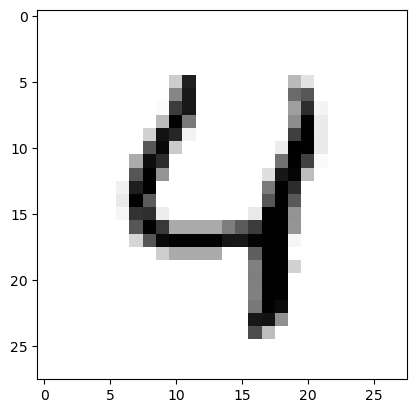

In [31]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt

# ścieżka powinna być poprawna jeżeli nie dokonano modyfikacji przykładu powyżej
imagefile = './data/MNIST/raw/t10k-images-idx3-ubyte'
imagearray = idx2numpy.convert_from_file(imagefile)

# wizualizacja jednego obrazu (z tablicy numpy, dane do modelu podawane są w formie numerycznej)
plt.imshow(imagearray[4], cmap=plt.cm.binary);

In [33]:
# inicjalizacja klasy modelu
model = Net()
# ładowanie wag modelu z pliku
model.load_state_dict(torch.load("mnist_cnn.pt", weights_only=True))
# ustawienie modelu w tryb ewaluacji (predykcji)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [35]:
# ustawiamy ile obrazów będzie ładowanych do tensora przy pojedynczej iteracji test loadera
batch_size = 8

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])
test_kwargs = {'batch_size': batch_size}

# inicjalizacja zbioru jak w skrypcie głównym
dataset2 = datasets.MNIST('./data', train=False, transform=transform)

# inicjalizacja data loadera tak jak w głównej pętli
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

<Figure size 640x480 with 0 Axes>

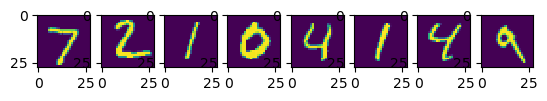

target: tensor([7, 2, 1, 0, 4, 1, 4, 9])
Predykcja: tensor([7, 2, 1, 0, 4, 1, 4, 9])


<Figure size 640x480 with 0 Axes>

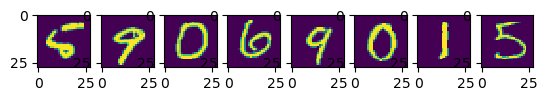

target: tensor([5, 9, 0, 6, 9, 0, 1, 5])
Predykcja: tensor([5, 9, 0, 6, 9, 0, 1, 5])


<Figure size 640x480 with 0 Axes>

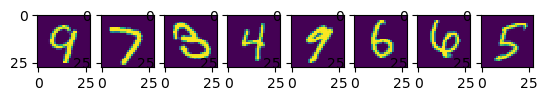

target: tensor([9, 7, 3, 4, 9, 6, 6, 5])
Predykcja: tensor([9, 7, 3, 4, 9, 6, 6, 5])


<Figure size 640x480 with 0 Axes>

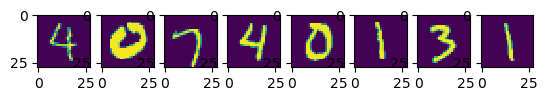

target: tensor([4, 0, 7, 4, 0, 1, 3, 1])
Predykcja: tensor([4, 0, 7, 4, 0, 1, 3, 1])


<Figure size 640x480 with 0 Axes>

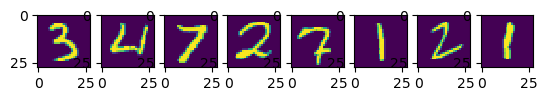

target: tensor([3, 4, 7, 2, 7, 1, 2, 1])
Predykcja: tensor([3, 4, 7, 2, 7, 1, 2, 1])


In [37]:
# ustalenie ile iteracji ładowania danych z data loadera obsłuży poniższa pętla
# cały zbiór testowy zawiera 10k obrazów, więc nie chcemy ich tutaj wczystkich wyświetlać
# co na pewno zawiesiłoby przeglądarkę
batches = 5 # ostrożnie!
start = 0

for data, target in test_loader:
    plt.figure()
    f, axarr = plt.subplots(1, batch_size)
    for idx, img in enumerate(data):
        axarr[idx].imshow(img.squeeze(), interpolation='nearest')
    plt.show()
    print(f"target: {target}")
    with torch.no_grad():
        output = model(data)
        _, predicted_classes = torch.max(output, 1)
        print(f"Predykcja: {predicted_classes}")
    start += 1
    if start == batches:
        break

### Zadanie 4

=== Zadanie 4: Predykcja dla 8 wsadów ===


<Figure size 640x480 with 0 Axes>

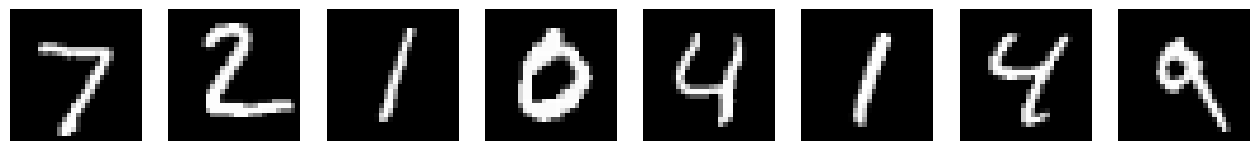

Etykiety: [7, 2, 1, 0, 4, 1, 4, 9]
Predykcje: [7, 2, 1, 0, 4, 1, 4, 9]


<Figure size 640x480 with 0 Axes>

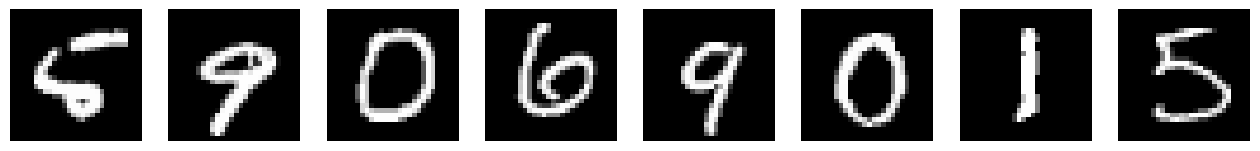

Etykiety: [5, 9, 0, 6, 9, 0, 1, 5]
Predykcje: [5, 9, 0, 6, 9, 0, 1, 5]


<Figure size 640x480 with 0 Axes>

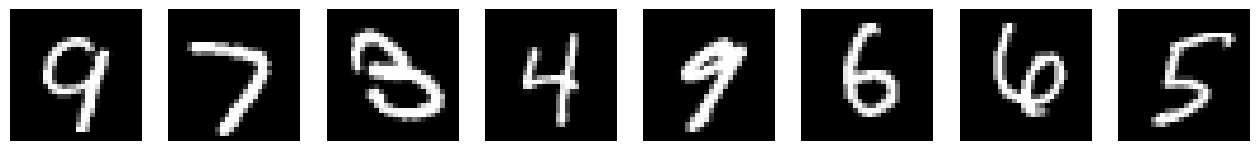

Etykiety: [9, 7, 3, 4, 9, 6, 6, 5]
Predykcje: [9, 7, 3, 4, 9, 6, 6, 5]


<Figure size 640x480 with 0 Axes>

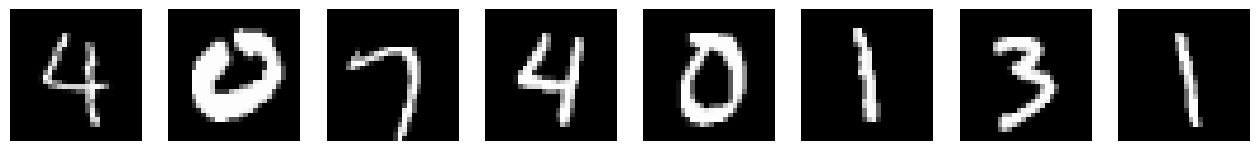

Etykiety: [4, 0, 7, 4, 0, 1, 3, 1]
Predykcje: [4, 0, 7, 4, 0, 1, 3, 1]


<Figure size 640x480 with 0 Axes>

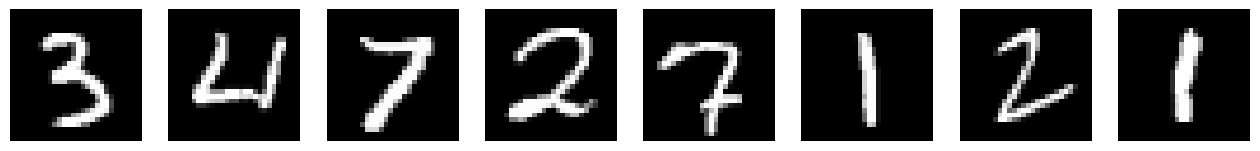

Etykiety: [3, 4, 7, 2, 7, 1, 2, 1]
Predykcje: [3, 4, 7, 2, 7, 1, 2, 1]


<Figure size 640x480 with 0 Axes>

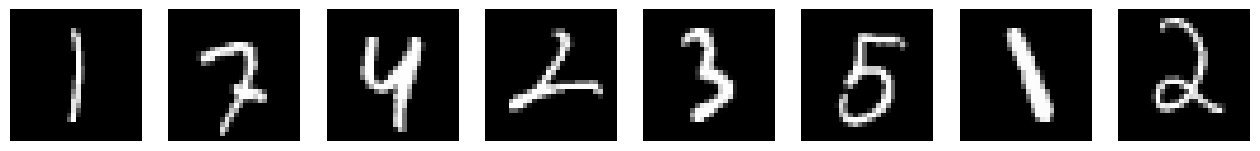

Etykiety: [1, 7, 4, 2, 3, 5, 1, 2]
Predykcje: [1, 7, 4, 2, 3, 5, 1, 2]


<Figure size 640x480 with 0 Axes>

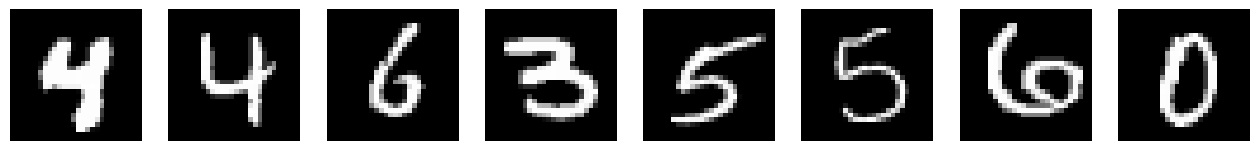

Etykiety: [4, 4, 6, 3, 5, 5, 6, 0]
Predykcje: [4, 4, 6, 3, 5, 5, 6, 0]


<Figure size 640x480 with 0 Axes>

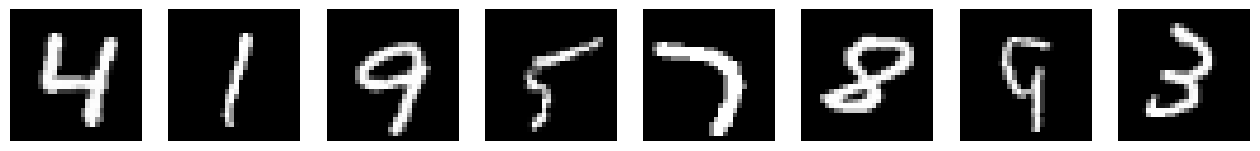

Etykiety: [4, 1, 9, 5, 7, 8, 9, 3]
Predykcje: [4, 1, 9, 5, 7, 8, 5, 3]


In [40]:
print("=== Zadanie 4: Predykcja dla 8 wsadów ===")
batch_limit = 8
batch_count = 0
for data, target in test_loader:
    if batch_count >= batch_limit:
        break
    plt.figure()
    f, axarr = plt.subplots(1, 8, figsize=(16, 2))
    for idx, img in enumerate(data):
        axarr[idx].imshow(img.squeeze(), cmap='gray', interpolation='nearest')
        axarr[idx].axis('off')
    plt.show()
    print(f"Etykiety: {target.tolist()}")
    with torch.no_grad():
        output = model(data)
        _, predicted_classes = torch.max(output, 1)
        print(f"Predykcje: {predicted_classes.tolist()}")
    batch_count += 1

=== Zadanie 5: Błędne klasyfikacje ===


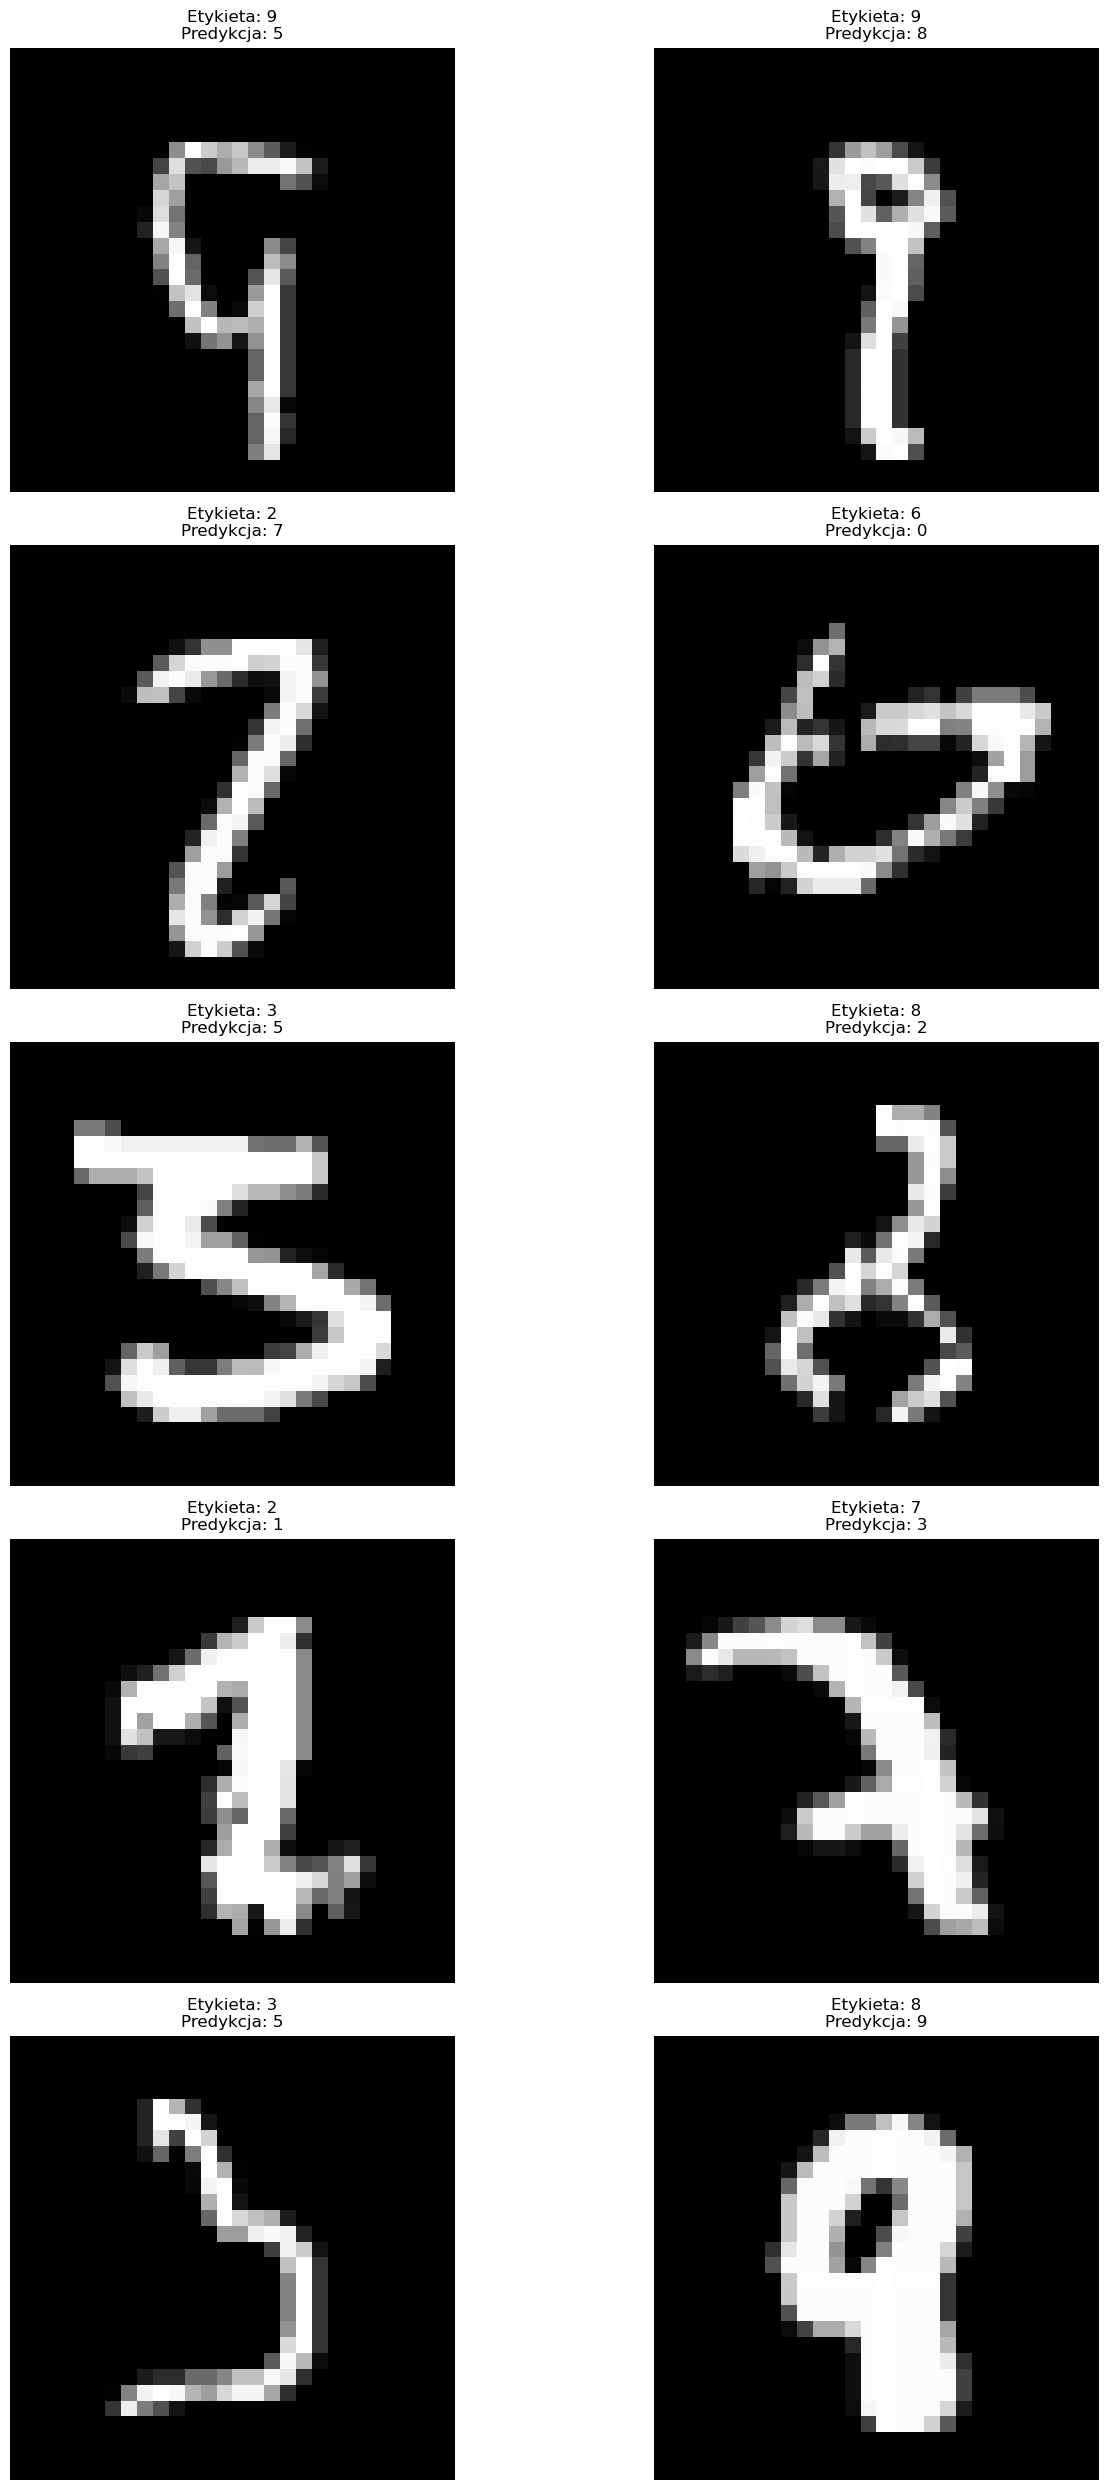

In [62]:
print("=== Zadanie 5: Błędne klasyfikacje ===")
incorrect_indices = []
incorrect_images = []
incorrect_labels = []
incorrect_predictions = []

for data, target in test_loader:
    with torch.no_grad():
        output = model(data)
        _, predicted_classes = torch.max(output, 1)
        for idx, (prediction, label) in enumerate(zip(predicted_classes, target)):
            if prediction != label:
                incorrect_indices.append(idx)
                incorrect_images.append(data[idx].squeeze())
                incorrect_labels.append(label.item())
                incorrect_predictions.append(prediction.item())

# Wyświetlenie 10 błędnych klasyfikacji
num_to_display = 10
rows = num_to_display // 2
cols = 2

plt.figure(figsize=(15, rows * 5))
for i in range(num_to_display):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(incorrect_images[i], cmap='gray', interpolation='nearest')
    plt.title(f"Etykieta: {incorrect_labels[i]}\nPredykcja: {incorrect_predictions[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Powód błędnej klasyfikacji jest widoczny na pierwszy rzut oka - cyfry są niewyraźne, zapisane niestarannie i często niekompletne